In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [46]:
# Set file path
data_path = "financial_data/"

# Load Aker BP Weekly Data (Dependent Variable)
aker_bp_weekly = pd.read_csv(data_path + "Aker_BP_weekly.csv", parse_dates=["Date"], index_col="Date")

# Load Independent Variables (Exogenous)
oil_prices = pd.read_csv(data_path + "Brent_Crude_weekly.csv", parse_dates=["Date"], index_col="Date")
osebx = pd.read_csv(data_path + "OSEBX_weekly.csv", parse_dates=["Date"], index_col="Date")
us_treasury = pd.read_csv(data_path + "US_10Yr_Treasury_weekly.csv", parse_dates=["Date"], index_col="Date")

In [47]:
import pandas as pd

# Set file path
data_path = "financial_data/"

# Function to load weekly data and convert "YYYY-WW" format to datetime (Monday of the week)
def load_weekly_data(filename, value_col):
    df = pd.read_csv(data_path + filename)
    
    # Convert "YYYY-WW" format to datetime (Monday of each week)
    df['Date'] = pd.to_datetime(df['Date'] + '-1', format='%Y-%W-%w')

    # Set Date as index
    df.set_index('Date', inplace=True)

    # Keep only the relevant column
    df = df[[value_col]]
    
    return df

# Load datasets with proper datetime indexing
aker_bp_weekly = load_weekly_data("Aker_BP_weekly.csv", "Log_Returns")
oil_prices = load_weekly_data("Brent_Crude_weekly.csv", "Log_Returns")
osebx = load_weekly_data("OSEBX_weekly.csv", "Log_Returns")
us_treasury = load_weekly_data("US_10Yr_Treasury_weekly.csv", "Log_Returns")

# Merge datasets using outer join to retain all dates
merged_df = aker_bp_weekly.copy()

# Dictionary of exogenous variables
exogenous_vars = {
    "Oil_Price": oil_prices,
    "OSEBX": osebx,
    "US_Treasury": us_treasury
}

# Merge all datasets
for var_name, df in exogenous_vars.items():
    merged_df = merged_df.merge(df, left_index=True, right_index=True, how='outer')
    merged_df.rename(columns={df.columns[0]: var_name}, inplace=True)  # Rename for clarity

# Remove duplicate dates (if any)
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

# Reindex to keep the original weekly timestamps
merged_df = merged_df.reindex(aker_bp_weekly.index)  # Ensure all dates match Aker BP weekly data

# Fill missing values
merged_df.ffill(inplace=True)  # Forward-fill missing values
merged_df.bfill(inplace=True)  # Backward-fill as a fallback

# Check for any remaining NaNs
print("\nMissing values after filling:")
print(merged_df.isnull().sum())

# Display first few rows
print(merged_df.head())



Missing values after filling:
Log_Returns_x    0
Log_Returns_y    0
OSEBX            0
US_Treasury      0
dtype: int64
            Log_Returns_x  Log_Returns_y     OSEBX  US_Treasury
Date                                                           
2014-01-06      -0.006842      -0.008292  0.000433     0.003344
2014-01-13      -0.004474       0.000672  0.003188    -0.009225
2014-01-20       0.006296      -0.000355  0.002570    -0.002321
2014-01-27      -0.004124       0.002543 -0.005097    -0.008271
2014-02-03      -0.003896      -0.002763 -0.004117    -0.004960


            Log_Returns_x  Log_Returns_y     OSEBX  US_Treasury
Date                                                           
2014-01-06      -0.006842      -0.008292  0.000433     0.003344
2014-01-13      -0.004474       0.000672  0.003188    -0.009225
2014-01-20       0.006296      -0.000355  0.002570    -0.002321
2014-01-27      -0.004124       0.002543 -0.005097    -0.008271
2014-02-03      -0.003896      -0.002763 -0.004117    -0.004960
                               SARIMAX Results                                
Dep. Variable:          Log_Returns_x   No. Observations:                  521
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1723.265
Date:                Thu, 20 Mar 2025   AIC                          -3434.530
Time:                        12:55:44   BIC                          -3409.030
Sample:                    01-06-2014   HQIC                         -3424.539
                         - 12-25-2023                                         

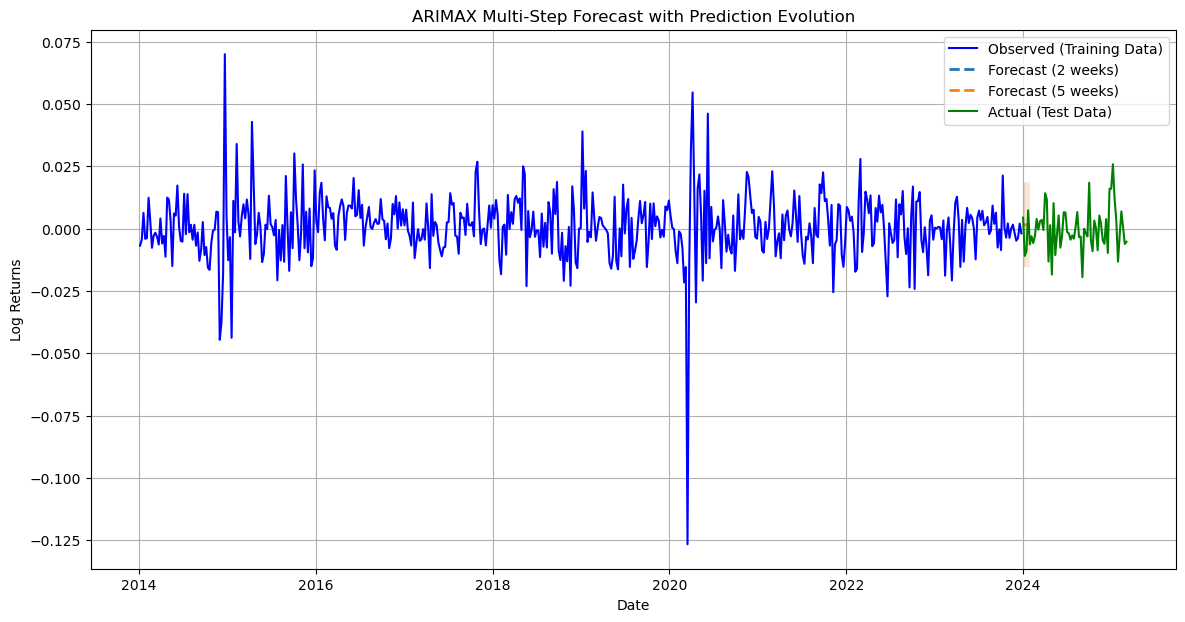


📊 Performance Summary for Different Forecast Horizons:
   Horizon       MSE       MAE       SMAPE  R² Score
0        2  0.000083  0.007745  151.733392 -0.401731
1        5  0.000075  0.007954  166.932838 -0.369808


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure proper datetime format in index
merged_df.index = pd.to_datetime(merged_df.index)

# **Fix: Remove Duplicate Dates**
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

# **Fix: Explicitly set weekly frequency to MONDAY**
merged_df = merged_df.asfreq('W-MON')

# Fill any remaining missing values
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)

# Define time range for training
train_end = pd.to_datetime("2023-12-31")  # Ensure train_end is in datetime format

# Split dataset into train & test sets
train_data = merged_df.loc[:train_end]
test_data = merged_df.loc[train_end:]

print(train_data.head())

# Define dependent (target) and exogenous (independent) variables
Y_train = train_data['Log_Returns_x']
X_train = train_data[['Log_Returns_y', 'OSEBX', 'US_Treasury']].copy()

# Ensure exogenous variables have no missing values
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.ffill(inplace=True)
X_train.bfill(inplace=True)

# Ensure Y_train is aligned with X_train
Y_train = Y_train.loc[X_train.index]

# **Fix: Check for missing values before fitting**
if Y_train.isnull().any():
    print("\n⚠️ Warning: Missing values found in Y_train!")
    Y_train.fillna(method='ffill', inplace=True)

if X_train.isnull().any().sum() > 0:
    print("\n⚠️ Warning: Missing values found in X_train!")
    X_train.fillna(method='ffill', inplace=True)

# Define ARIMAX order
order = (1, 1, 1)

# Train ARIMAX model
model = SARIMAX(Y_train, exog=X_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Print model summary
print(results.summary())

# **Prediction Horizons: 2 and 5 weeks**
forecast_horizons = [2,5    ]
performance_metrics = []

def smape(actual, predicted): 
    return 100 * np.mean(np.abs(predicted - actual) / ((np.abs(actual) + np.abs(predicted)) / 2))

plt.figure(figsize=(14, 7))

# Plot observed values
plt.plot(train_data.index, train_data['Log_Returns_x'], label='Observed (Training Data)', color='blue')

# Store forecasted values for stepwise plotting
all_forecasts = {}

for forecast_steps in forecast_horizons:
    # Generate forecast index
    forecast_dates = pd.date_range(start=train_data.index[-1] + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W-MON')

    # Use the last known exogenous values for forecasting
    future_exog_df = pd.DataFrame(
        np.tile(X_train.iloc[-1].values, (forecast_steps, 1)),  # Repeat last known values
        index=forecast_dates,
        columns=X_train.columns
    )

    # Generate forecasts
    forecast = results.get_forecast(steps=forecast_steps, exog=future_exog_df)

    # Extract predicted values and confidence intervals
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Store forecast evolution
    all_forecasts[forecast_steps] = forecast_mean

    # Create forecast DataFrame
    forecast_df = pd.DataFrame({'Forecast': forecast_mean}, index=forecast_dates)
    forecast_df['Lower CI'] = forecast_ci.iloc[:, 0]
    forecast_df['Upper CI'] = forecast_ci.iloc[:, 1]

    # **Fix: Compare to actual values properly**
    if forecast_dates[-1] in test_data.index:
        actual_values = test_data.reindex(forecast_dates)['Log_Returns_x']

        # Compute error metrics
        mse = mean_squared_error(actual_values, forecast_mean)
        mae = mean_absolute_error(actual_values, forecast_mean)
        smape_value = smape(actual_values, forecast_mean) # Percentage error
        r2 = r2_score(actual_values, forecast_mean)

        performance_metrics.append({
            'Horizon': forecast_steps,
            'MSE': mse,
            'MAE': mae,
            'SMAPE': smape_value,
            'R² Score': r2
        })

        # Print metrics
        print(f"\n Performance for {forecast_steps}-week Forecast:")
        print(f"  - MSE: {mse:.4f}")
        print(f"  - MAE: {mae:.4f}")
        print(f"  - SMAPE: {smape_value:.2f}%")
        print(f"  - R² Score: {r2:.4f}")

    # **Plot rolling forecast paths**
    plt.plot(forecast_df.index, forecast_df['Forecast'], linestyle='dashed', label=f'Forecast ({forecast_steps} weeks)', linewidth=2)
    plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], alpha=0.2)

# Plot actual values in test data
plt.plot(test_data.index, test_data['Log_Returns_x'], label='Actual (Test Data)', color='green')

# Improve legend and labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('ARIMAX Multi-Step Forecast with Prediction Evolution')
plt.grid()
plt.show()

# **Display Performance Metrics**
performance_df = pd.DataFrame(performance_metrics)
print("\n📊 Performance Summary for Different Forecast Horizons:")
print(performance_df)


            Log_Returns_x  Log_Returns_y     OSEBX  US_Treasury
Date                                                           
2014-01-06      -0.006842      -0.008292  0.000433     0.003344
2014-01-13      -0.004474       0.000672  0.003188    -0.009225
2014-01-20       0.006296      -0.000355  0.002570    -0.002321
2014-01-27      -0.004124       0.002543 -0.005097    -0.008271
2014-02-03      -0.003896      -0.002763 -0.004117    -0.004960
                               SARIMAX Results                                
Dep. Variable:          Log_Returns_x   No. Observations:                  521
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1723.265
Date:                Thu, 20 Mar 2025   AIC                          -3434.530
Time:                        12:57:49   BIC                          -3409.030
Sample:                    01-06-2014   HQIC                         -3424.539
                         - 12-25-2023                                         

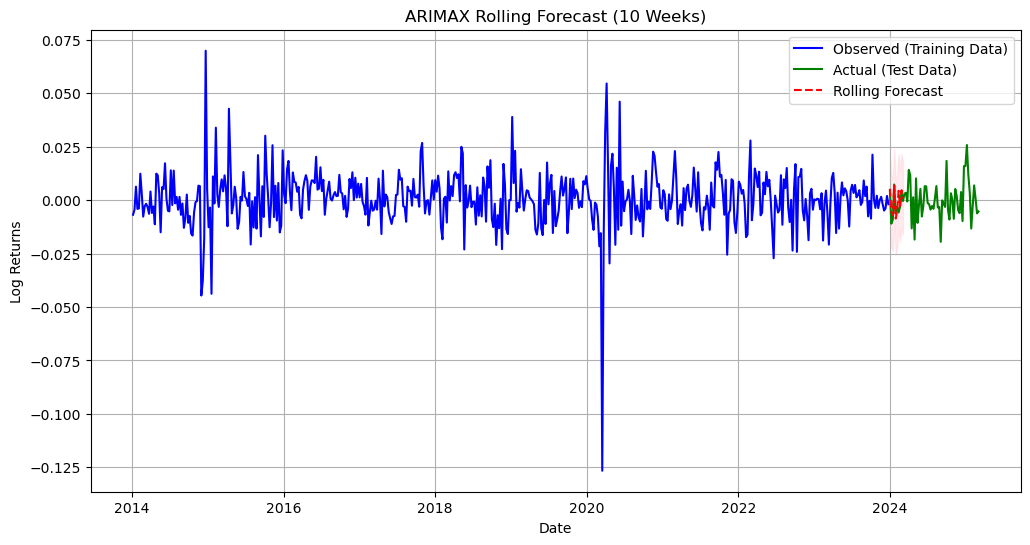

In [ ]:
import seaborn as sns

# Apply Seaborn style
sns.set_style("whitegrid")

# **Plot 1: Forecast Evolution Over Time (Full Dataset)**
plt.figure(figsize=(12, 6))

# Plot observed log-returns
sns.lineplot(x=train_data.index, y=train_data['Log_Returns_x'], label='Observed (Training Data)', color='blue')

# Plot actual test values
sns.lineplot(x=test_data.index, y=test_data['Log_Returns_x'], label='Actual (Test Data)', color='green')

# Plot forecast evolution
sns.lineplot(x=forecast_df.index, y=forecast_df['Forecast'], linestyle='dashed', color='red', label='Rolling Forecast')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)

# Improve legend and labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('ARIMAX Rolling Forecast (10 Weeks)')
plt.show()

# **Plot 2: Focus on Prediction Period Only**
plt.figure(figsize=(10, 5))

# Plot actual test values (Zoomed in)
sns.lineplot(x=test_data.loc[forecast_df.index].index, y=test_data.loc[forecast_df.index]['Log_Returns_x'], label='Actual (Test Data)', color='green')

# Plot forecast evolution (Zoomed in)
sns.lineplot(x=forecast_df.index, y=forecast_df['Forecast'], linestyle='dashed', color='red', label='Rolling Forecast')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)

# Improve legend and labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('ARIMAX Forecast (Zoomed-In: Prediction Period)')
plt.show()


In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def smape(actual, predicted): 
    """ Symmetric Mean Absolute Percentage Error """
    return 100 * np.mean(np.abs(predicted - actual) / ((np.abs(actual) + np.abs(predicted)) / 2))

# Ensure actual values exist for comparison
actual_values = test_data.reindex(forecast_df.index)['Log_Returns_x']

# Compute error metrics
mse = mean_squared_error(actual_values, forecast_df['Forecast'])
mae = mean_absolute_error(actual_values, forecast_df['Forecast'])
smape_value = smape(actual_values, forecast_df['Forecast'])
r2 = r2_score(actual_values, forecast_df['Forecast'])

# Store performance results in a DataFrame
performance_results = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'SMAPE', 'R² Score'],
    'Value': [mse, mae, smape_value, r2]
})

print(performance_results) 


     Metric      Value
0       MSE   0.000015
1       MAE   0.002589
2     SMAPE  63.061769
3  R² Score   0.537711
